## Bayesian Network
#### Dropped 8 features, 30:70 train:test ratio.
#### ~91% accuracy

In [677]:
import pandas as pd

df = pd.read_csv('../3_to_classes_.csv').map(str)
df = df.drop(columns=[ 'AnyHealthcare', 'NoDocbcCost', 'Smoker','Sex', 'Veggies', 'Fruits', 'CholCheck', 'Education' ])
train = df.sample(frac=0.30, random_state = 87)
test = df.drop(train.index) 

In [678]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BIC, HillClimbSearch

hillclimb = HillClimbSearch(train)
model = hillclimb.estimate(scoring_method=BIC(train))

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Diabetes_binary': 'C', 'HighBP': 'C', 'HighChol': 'C', 'NEW_BMI_class': 'C', 'Stroke': 'C', 'HeartDiseaseorAttack': 'C', 'PhysActivity': 'C', 'HvyAlcoholConsump': 'C', 'GenHlth': 'C', 'MetHlth_Class': 'C', 'PhyHlth_Class': 'C', 'DiffWalk': 'C', 'Age': 'C', 'Income': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Diabetes_binary': 'C', 'HighBP': 'C', 'HighChol': 'C', 'NEW_BMI_class': 'C', 'Stroke': 'C', 'HeartDiseaseorAttack': 'C', 'PhysActivity': 'C', 'HvyAlcoholConsump': 'C', 'GenHlth': 'C', 'MetHlth_Class': 'C', 'PhyHlth_Class': 'C', 'DiffWalk': 'C', 'Age': 'C', 'Income': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Diabetes_binary': 'C', 'HighBP': 'C', 'HighChol': 'C', 'NEW_BMI_class': 'C', 'Stroke': 'C', 'HeartDiseaseorAttack': 'C', 'PhysActivity'

  0%|          | 0/1000000 [00:00<?, ?it/s]

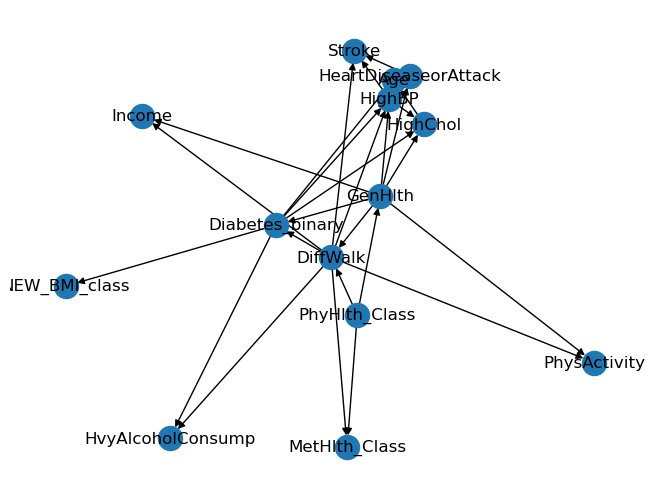

In [679]:
bayes = DiscreteBayesianNetwork(model)

import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_nodes_from(bayes.nodes())
G.add_edges_from(bayes.edges())
nx.draw(G, with_labels=True)
plt.draw()

In [680]:
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
  
bayes.fit(train, estimator=MaximumLikelihoodEstimator)
predict = VariableElimination(bayes)
print(bayes.get_independencies())

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Diabetes_binary': 'C', 'HighBP': 'C', 'HighChol': 'C', 'NEW_BMI_class': 'C', 'Stroke': 'C', 'HeartDiseaseorAttack': 'C', 'PhysActivity': 'C', 'HvyAlcoholConsump': 'C', 'GenHlth': 'C', 'MetHlth_Class': 'C', 'PhyHlth_Class': 'C', 'DiffWalk': 'C', 'Age': 'C', 'Income': 'C'}


(MetHlth_Class ⟂ GenHlth | DiffWalk, PhyHlth_Class)
(HeartDiseaseorAttack ⟂ PhyHlth_Class | Age, GenHlth)
(Age ⟂ GenHlth | Diabetes_binary, HighBP, HighChol)
(Stroke ⟂ HighChol | HighBP, DiffWalk, HeartDiseaseorAttack)
(GenHlth ⟂ HvyAlcoholConsump | Diabetes_binary, DiffWalk)
(HighBP ⟂ Income | GenHlth, DiffWalk)
(Age ⟂ PhyHlth_Class | HighBP, Diabetes_binary, HighChol)
(NEW_BMI_class ⟂ HighBP | Diabetes_binary)
(HighBP ⟂ HvyAlcoholConsump | Diabetes_binary, DiffWalk)
(Age ⟂ HvyAlcoholConsump | Diabetes_binary, DiffWalk)
(Stroke ⟂ Diabetes_binary | HighBP, DiffWalk, HeartDiseaseorAttack)
(PhysActivity ⟂ PhyHlth_Class | GenHlth, DiffWalk)
(HighChol ⟂ HeartDiseaseorAttack | Age, GenHlth)
(MetHlth_Class ⟂ HighBP | DiffWalk, PhyHlth_Class)
(NEW_BMI_class ⟂ HvyAlcoholConsump | Diabetes_binary)
(PhysActivity ⟂ HvyAlcoholConsump | GenHlth, DiffWalk)
(HvyAlcoholConsump ⟂ HeartDiseaseorAttack | Diabetes_binary, DiffWalk)
(Income ⟂ Diabetes_binary | GenHlth, DiffWalk)
(Income ⟂ HeartDiseaseorAtt

In [681]:
import math
correct, total = 0,0
print("Computing Accuracy for Test Set")
y_true, y_pred = [],[]

for i, row in test.iterrows():
    evidence = dict(row.iloc[1:])
    result = predict.query(variables=['Diabetes_binary'], evidence=evidence, joint = True).values[1]
    if(math.isnan(result)):
        print("nan")
        result = 1
    if(str(round(result)) == row['Diabetes_binary']):
        correct+=1
    total+=1
    y_true.append(row['Diabetes_binary'])
    y_pred.append(str(round(result)))

print(f"Test Accuracy: {(correct*100)/total}")

Computing Accuracy for Test Set
Test Accuracy: 91.20927976719747


In [682]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[22597  2053]
 [ 2297 22537]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     24650
           1       0.92      0.91      0.91     24834

    accuracy                           0.91     49484
   macro avg       0.91      0.91      0.91     49484
weighted avg       0.91      0.91      0.91     49484



In [683]:
correct, total = 0,0
print("Computing Accuracy for Train Set")
y_true, y_pred = [],[]

for i, row in train.iterrows():
    evidence = dict(row.iloc[1:])
    result = predict.query(variables=['Diabetes_binary'], evidence=evidence, joint = True).values[1]
    if(math.isnan(result)):
        print("nan")
        result = 1
    if(str(round(result)) == row['Diabetes_binary']):
        correct+=1
    total+=1
    y_true.append(row['Diabetes_binary'])
    y_pred.append(str(round(result)))

print(f"Test Accuracy: {(correct*100)/total}")

Computing Accuracy for Train Set
Test Accuracy: 91.2485854394568


In [684]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[9821  875]
 [ 981 9531]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     10696
           1       0.92      0.91      0.91     10512

    accuracy                           0.91     21208
   macro avg       0.91      0.91      0.91     21208
weighted avg       0.91      0.91      0.91     21208



In [685]:
bayes.save("bayesian_network.bif", filetype="bif")